## Objetivo del proyecto ###

El presente documento tiene como objetivo demostrar con diversos métodos e hipótesis cuáles son los operadores telefónicos menos eficaces sobre una base de datos del servicio de telefonía virtual CallMeMaybe, tomando en cuenta las características de las llamadas y el comportamiento de los operadores. 

Partiremos de tres premisas que se establecieron en la etapa de Descomposición del proyecto: 

*Los operadores que realizan más llamadas internas tienen más llamadas perdidas.

*Los operadores con menor duración de tiempo de llamadas tienen más llamadas totales.

*Las llamadas salientes duran más que las entrantes.

A su vez, realizaremos una exploración de datos para nutrir más la información y saber cuáles son los tiempos promedio y la tasa de llamadas perdidas por operador. Obtendremos los percentiles de algunas características para encontrar los datos que podrían considerarse normales y así deshacernos de aquellos que están muy alejados de los datos típicos.

Link para carpeta de Google Drive: https://drive.google.com/drive/folders/1zNPN-rc864mihiBRbfms4KOfF0QSr45b?usp=drive_link

Link de proyecto dashboard Tableau: https://public.tableau.com/views/DashboardSprint14/Dashboard1?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link


In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import math as mth
from scipy import stats as st
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import levene

dataset = pd.read_csv('/datasets/telecom_dataset_us.csv')
clients = pd.read_csv('/datasets/telecom_clients_us.csv')


all_data = dataset.merge(clients, on = 'user_id')
#print(dataset)
print(all_data.head(15))

    user_id                       date direction internal  operator_id  \
0    166377  2019-08-04 00:00:00+03:00        in    False          NaN   
1    166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
2    166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
3    166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
4    166377  2019-08-05 00:00:00+03:00       out    False     880022.0   
5    166377  2019-08-05 00:00:00+03:00       out    False     880020.0   
6    166377  2019-08-05 00:00:00+03:00       out    False     880020.0   
7    166377  2019-08-05 00:00:00+03:00        in    False          NaN   
8    166377  2019-08-05 00:00:00+03:00       out    False     880020.0   
9    166377  2019-08-06 00:00:00+03:00        in    False          NaN   
10   166377  2019-08-06 00:00:00+03:00       out    False     881278.0   
11   166377  2019-08-06 00:00:00+03:00       out    False     880020.0   
12   166377  2019-08-06 00:00:00+03:00

Se realizó una lectura de datos y también se unieron las dos bases de datos para tener una sola fuente con toda la información. Ahora, se hará revisión de los tipos de datos para cambiarlos y/o eliminar aquellos que no son sujetos a tomarlos en cuenta.

In [2]:
# Se eliminan las filas que no tienen identificados a los operadores para no sesgar la información y/o tenr información irrelevante.
clean_data = all_data.dropna(subset = ['operator_id'])

# Se convierten las columnas 'date' y 'date_start' a tipo datetime
clean_data['date'] = pd.to_datetime(clean_data['date']) 
clean_data['date_start'] = pd.to_datetime(clean_data['date_start'])


# Se convierten los datos tipo object de la columna 'internal' a tipo booleano y posteriormente a 0 y 1 para mejor conteo
clean_data['internal'] = clean_data['internal'].astype(bool)
clean_data['internal'] = clean_data['internal'].astype(int)

# Se convierten los datos tipo bool de la columna 'is_missed_call' a 0 y 1 para mejor conteo
clean_data['is_missed_call'] = clean_data['is_missed_call'].astype(int)


# Eliminamos las filas duplicadas 
clean_data = clean_data.drop_duplicates()

# Convertimos la columna 'operator_id' a tipo entero
clean_data['operator_id'] = clean_data['operator_id'].astype(int)
print(clean_data.head(15))
print(clean_data.info())

    user_id                      date direction  internal  operator_id  \
1    166377 2019-08-05 00:00:00+03:00       out         1       880022   
2    166377 2019-08-05 00:00:00+03:00       out         1       880020   
3    166377 2019-08-05 00:00:00+03:00       out         1       880020   
4    166377 2019-08-05 00:00:00+03:00       out         0       880022   
5    166377 2019-08-05 00:00:00+03:00       out         0       880020   
6    166377 2019-08-05 00:00:00+03:00       out         0       880020   
10   166377 2019-08-06 00:00:00+03:00       out         0       881278   
11   166377 2019-08-06 00:00:00+03:00       out         0       880020   
12   166377 2019-08-06 00:00:00+03:00       out         1       881278   
13   166377 2019-08-06 00:00:00+03:00       out         0       880020   
14   166377 2019-08-07 00:00:00+03:00       out         0       880028   
15   166377 2019-08-07 00:00:00+03:00       out         0       880026   
16   166377 2019-08-07 00:00:00+03:00 

/tmp/ipykernel_325/3448885069.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['date'] = pd.to_datetime(clean_data['date'])
/tmp/ipykernel_325/3448885069.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['date_start'] = pd.to_datetime(clean_data['date_start'])
/tmp/ipykernel_325/3448885069.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

Se hizo la conversión de las columnas a los tipos de datos adecuados para los análisis que se realizarán y se eliminaron las filas duplicadas. El tener los datos limpios y en una sola variable nos permitirá trabajar más fácilmente y aprovechar mejor los recursos.

Para convertir los datos booleanos a 1 y 0, se consultó este link: https://www.geeksforgeeks.org/python/map-true-false-to-1-0-in-a-pandas-dataframe/

In [3]:
# Se obtiene el tiempo de espera por fila
clean_data['wait_time'] = clean_data['total_call_duration'] - clean_data['call_duration']
clean_data['wait_time_per_call'] = clean_data['wait_time'] / clean_data['calls_count']
clean_data['avg_total_call_duration'] = clean_data['total_call_duration'] / clean_data['calls_count']
print(clean_data)

       user_id                      date direction  internal  operator_id  \
1       166377 2019-08-05 00:00:00+03:00       out         1       880022   
2       166377 2019-08-05 00:00:00+03:00       out         1       880020   
3       166377 2019-08-05 00:00:00+03:00       out         1       880020   
4       166377 2019-08-05 00:00:00+03:00       out         0       880022   
5       166377 2019-08-05 00:00:00+03:00       out         0       880020   
...        ...                       ...       ...       ...          ...   
53895   168606 2019-11-09 00:00:00+03:00       out         0       957922   
53896   168606 2019-11-10 00:00:00+03:00       out         1       957922   
53897   168606 2019-11-10 00:00:00+03:00       out         1       957922   
53898   168606 2019-11-11 00:00:00+03:00       out         1       957922   
53899   168606 2019-11-15 00:00:00+03:00       out         1       957922   

       is_missed_call  calls_count  call_duration  total_call_duration  \
1

In [4]:
# Comprobación de que no hay valores duplicados.
print(clean_data[clean_data.duplicated(keep = False)].head(10))



Empty DataFrame
Columns: [user_id, date, direction, internal, operator_id, is_missed_call, calls_count, call_duration, total_call_duration, tariff_plan, date_start, wait_time, wait_time_per_call, avg_total_call_duration]
Index: []


Se agregaron 2 columnas para un mejor análisis: el tiempo de espera total y el tiempo de espera por llamada en las distintas condiciones, ya que esto nos permitirá sacar mejores métricas para los operadores. 

### Identificar valores atípicos ###

In [5]:
print('Percentiles espera por llamada:', np.percentile(clean_data['wait_time_per_call'], [90, 95, 97]))


Percentiles espera por llamada: [31.         37.88541667 42.7375    ]


Para las duraciones promedio de las llamadas por evento, estableceremos los valores atípicos para las llamadas de más de 45 minutos de espera, ya que observamos que el percentil del 95% obtuvo 37.88 y en 99% obtuvo 56.5.

In [6]:
# Obtenemos los clientes que no están dentro de los valores atípicos.
filtered_data = clean_data[clean_data['wait_time_per_call'] < 45]
print(filtered_data.sort_values(by = 'wait_time_per_call'))

       user_id                      date direction  internal  operator_id  \
9578    166658 2019-11-08 00:00:00+03:00       out         1       890406   
25045   167125 2019-09-20 00:00:00+03:00       out         1       902744   
52474   168361 2019-11-10 00:00:00+03:00       out         1       945302   
50984   168253 2019-11-07 00:00:00+03:00       out         1       952948   
43522   167999 2019-10-30 00:00:00+03:00       out         0       933806   
...        ...                       ...       ...       ...          ...   
42770   167977 2019-10-25 00:00:00+03:00        in         0       944216   
52126   168361 2019-10-30 00:00:00+03:00       out         0       945314   
15013   166879 2019-11-16 00:00:00+03:00        in         0       896536   
19230   166983 2019-10-24 00:00:00+03:00        in         0       909134   
34878   167521 2019-10-12 00:00:00+03:00        in         0       919794   

       is_missed_call  calls_count  call_duration  total_call_duration  \
9

### Operadores menos eficaces (cantidad de llamadas entrantes perdidas,tiempo de espera prolongado para llamadas entrantes y pocas llamadas salientes ) ###

In [7]:
only_in_calls = filtered_data[filtered_data['direction'] == 'in']
only_out_calls = filtered_data[filtered_data['direction'] == 'out']

inneficient = only_in_calls.groupby('operator_id', as_index = False).agg({'is_missed_call' : 'sum', 'wait_time' : 'sum'})
inneficient_out = only_out_calls.groupby('operator_id', as_index = False).agg({'direction' : 'count'})
inneficient_out.columns = ['operator_id', 'out_direction']
print('Percentiles llamadas perdidas:', np.percentile(inneficient['is_missed_call'], [90, 95, 99]))
print('Percentiles tiempo de espera:', np.percentile(inneficient['wait_time'], [90, 95, 99]))
print('Percentiles llamadas salientes:', np.percentile(inneficient_out['out_direction'], [5, 10, 20]))


top_missed_operator = inneficient[inneficient['is_missed_call'] > 5]
top_wait_operator = inneficient[inneficient['wait_time'] > 7000] 
less_out_operator = inneficient_out[inneficient_out['out_direction'] < 3]

#print(top_missed_operator)
#print(top_wait_operator)
#print(less_out_operator)

Percentiles llamadas perdidas: [ 2.   4.9 10. ]
Percentiles tiempo de espera: [ 3796.    6972.2  28074.44]
Percentiles llamadas salientes: [1. 2. 3.]


Para obtener los usuarios que han tenido una mayor cantidad de llamadas perdidas, se hizo un filtrado para obtener solo llamadas entrantes y después agrupar por operador la suma de la cantidad de llamadas perdidas y el tiempo total de espera del operador. Para saber cuáles operadores están por encima de los valores típicos para considerarlos ineficaces, usamos los percentiles y establecimos que la cantidad de llamadas perdidas para considerarlo ineficiente serían 5 llamadas; 7,000 minutos de espera en llamada por operador y el solo haber realizado menos de 3 llamadas salientes. 

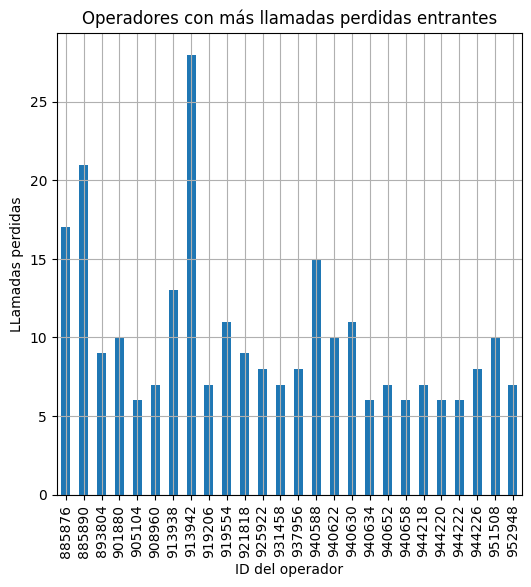

Total de operadores con más de 5 llamadas entrantes perdidas: 26


In [8]:
top_missed_operator.plot(x='operator_id', y='is_missed_call', kind='bar', figsize = [6, 6], title = 'Operadores con más llamadas perdidas entrantes', xlabel='ID del operador', ylabel='LLamadas perdidas', grid=True, legend = False)
plt.show()
print('Total de operadores con más de 5 llamadas entrantes perdidas:',len(top_missed_operator))

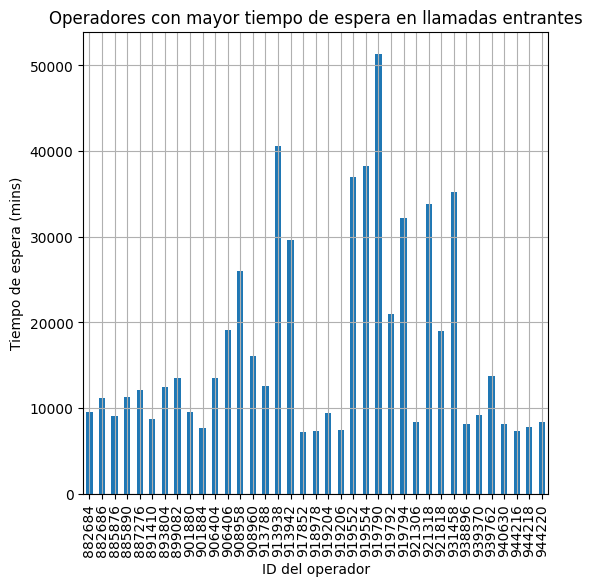

Total de operadores con más de 7,000 minutos de espera en llamadas entrantes: 37


In [9]:
top_wait_operator.plot(x='operator_id', y='wait_time', kind='bar', figsize = [6, 6], title = 'Operadores con mayor tiempo de espera en llamadas entrantes', xlabel='ID del operador', ylabel='Tiempo de espera (mins)', grid=True, legend = False)
plt.show()
print('Total de operadores con más de 7,000 minutos de espera en llamadas entrantes:',len(top_wait_operator))

También observamos que hay una gran cantidad de operadores que realizaron menos de 3 llamadas salientes, por lo que debemos de tomar esta información con cautela, ya que a pesar de hacer pocas llamadas salientes, es probable que en las otras áreas sean muy eficientes.

### Comprobación de que los operadores que realizan más llamadas internas tienen más llamadas perdidas ###

             internal  is_missed_call  calls_count
operator_id                                       
879896             15              42          923
879898             16              89         7303
880020              3               6           45
880022              8              24          175
880026             13              86         2231
...               ...             ...          ...
972410              0               2           77
972412              0               2           61
972460              2               3           51
973120              0               1            3
973286              0               0            2

[1087 rows x 3 columns]
                internal  is_missed_call  calls_count
internal        1.000000        0.465180     0.024134
is_missed_call  0.465180        1.000000     0.422597
calls_count     0.024134        0.422597     1.000000


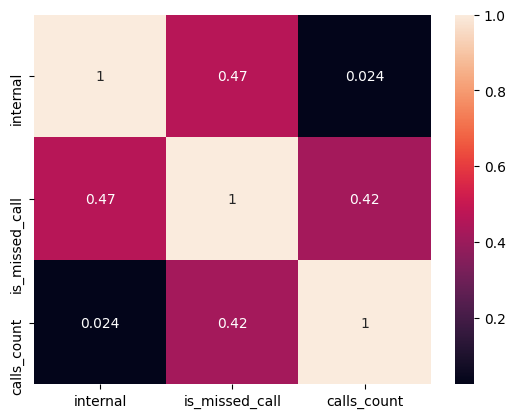

In [10]:

internal_operator_calls = filtered_data.groupby('operator_id').agg({'internal':'sum', 'is_missed_call': 'sum', 'calls_count' : 'sum'})

print(internal_operator_calls)

corr_operator = internal_operator_calls.corr()
print(corr_operator)

fig, ax = plt.subplots()

# traza el mapa de calor anotado para la matriz de correlación
sns.heatmap(corr_operator, annot=True)# escribe tu código aquí
plt.show()

Para esta comprobación, agrupamos las sumas de las llamadas internas y las llamadas perdidas por operador y aplicamos la función de correlación para afirmar si mientras más llamadas internas hay, igualmente más llamadas perdidas. Sin embargo, observamos que tenemos una correlación medianamente positiva de .46518, lo que nos indica que no hay ni una relación nula y tampoco una relación fuerte entre estas variables.

### Comprobación de que los operadores con menor duración de tiempo de llamadas tienen más llamadas totales. ###

             wait_time  calls_count
operator_id                        
879896           11865          923
879898          103140         7303
880020             280           45
880022            2634          175
880026           22154         2231
...                ...          ...
972410            1498           77
972412            1050           61
972460             620           51
973120              20            3
973286              88            2

[1087 rows x 2 columns]
             wait_time  calls_count
wait_time     1.000000     0.986985
calls_count   0.986985     1.000000


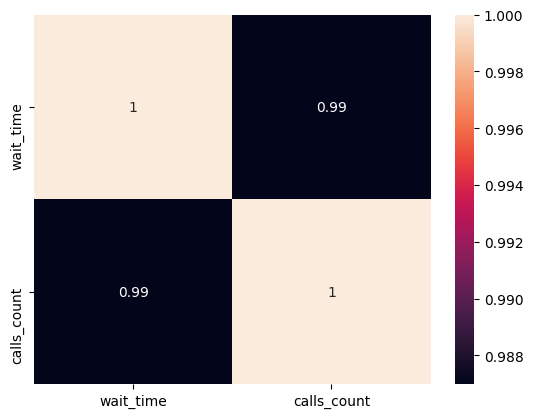

In [11]:
operator_stats = filtered_data.groupby('operator_id').agg({'wait_time': 'sum','calls_count': 'sum'})
corr_operator2 = operator_stats.corr()
print(operator_stats)
print(corr_operator2)          


fig, ax = plt.subplots()

# traza el mapa de calor anotado para la matriz de correlación
sns.heatmap(corr_operator2, annot=True)# escribe tu código aquí
plt.show()

Para este ejercicio, utilizamos la variable resultante de la resta de la duration total de llamada(con tiempo de espera incluido) y la duración de la llamada(sin tiempo de espera incluido), para así obtener el valor del tiempo de espera en la columna de 'wait_time'. Se esperaba que mientras mayor fuera el tiempo de espera, menor número de llamadas concretadas. En este caso, se esperaba que la correlación fuera negativa para poder confirmar este supuesto, sin embargo, la correlación fue positiva y muy fuerte, por lo que no se puede afirmar que los operadores que menos tiempo de espera tenian hicieron más llamadas.

Para entender un poco mejor esta comprobación, se visitó esta página : https://www.geeksforgeeks.org/pandas/python-pandas-dataframe-corr/

### Comprobación de que las llamadas salientes y entrantes duran lo mismo ### 

In [12]:
in_calls = filtered_data[filtered_data['direction'] == 'in']
out_calls = filtered_data[filtered_data['direction'] == 'out']


# Prueba Levene para confirmar si las varianzas son iguales
levene_result = levene(in_calls['avg_total_call_duration'], out_calls['avg_total_call_duration'])
print(levene_result)


alpha = .05# tu código: establece un nivel crítico de significación estadística

results = st.ttest_ind(in_calls['avg_total_call_duration'], out_calls['avg_total_call_duration'], equal_var = False)# tu código: prueba la hipótesis de que las medias de las dos poblaciones independientes son iguales

print('valor p:', results.pvalue) # tu código: imprime el valor p obtenido)

if (results.pvalue < alpha):
    print("Rechazamos la hipótesis nula. SÍ hay una diferencia significativa entre las medias de los datos")
else:
    print("No podemos rechazar la hipótesis nula. NO hay una diferencia significativa entre las medias de los datos")


LeveneResult(statistic=24.683175387461613, pvalue=6.784623397045145e-07)
valor p: 4.150113090601688e-207
Rechazamos la hipótesis nula. SÍ hay una diferencia significativa entre las medias de los datos


Para la comprobación de que las llamadas entrantes y salientes tienen la misma duración, utilizamos el método de la igualdad de las medias de dos poblaciones, tomando la columna del promedio de duración por llamada 'avg_total_call_duration'. El resultado nos arrojó que hay una diferencia significativa entre las medias de la duración de las llamadas entrantes y salientes, por lo que es posible que los operadores que hayan realizado más llamadas ya sea tanto entrante como saliente, hayan tenido diferencias también en la cantidad de llamadas realizadas. 

Para entender que esta prueba se realizó con el fin correcto, se consultó este artículo : https://docs.scipy.org/doc/scipy-1.16.1/reference/generated/scipy.stats.ttest_ind.html

### Hipótesis adicional: hay una cantidad igual de llamadas entrantes como salientes ###

In [13]:
# Prueba Levene para confirmar si las varianzas son iguales
levene_result = levene(in_calls['calls_count'], out_calls['calls_count'])
print(levene_result)

results = st.ttest_ind(in_calls['calls_count'], out_calls['calls_count'], equal_var = False)# tu código: prueba la hipótesis de que las medias de las dos poblaciones independientes son iguales

print('valor p:', results.pvalue) # tu código: imprime el valor p obtenido)

if (results.pvalue < alpha):
    print("Rechazamos la hipótesis nula. SÍ hay una diferencia significativa entre la cantidad de llamadas")
else:
    print("No podemos rechazar la hipótesis nula. NO hay una diferencia significativa entre la cantidad de llamadas")


LeveneResult(statistic=418.35326422269713, pvalue=1.6364994549142723e-92)
valor p: 4.6926382311277047e-212
Rechazamos la hipótesis nula. SÍ hay una diferencia significativa entre la cantidad de llamadas


  direction  cantidad
0        in     92633
1       out    606939


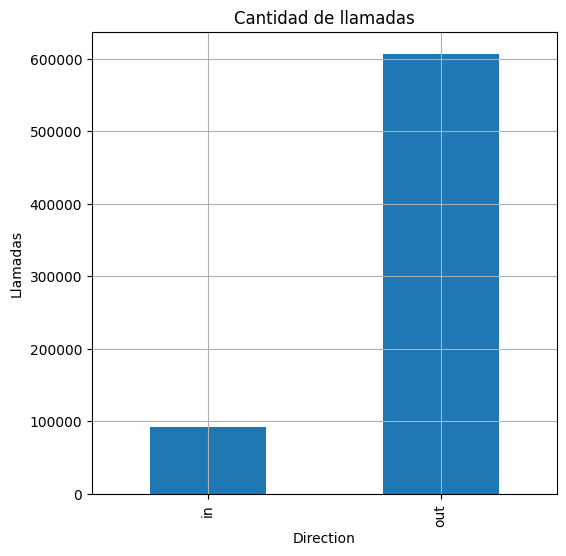

In [14]:
len_in = filtered_data[filtered_data['direction'] == 'in']['calls_count'].sum()

len_out = filtered_data[filtered_data['direction'] == 'out']['calls_count'].sum()

y = [len_in, len_out]
x = ['in', 'out']

datos = {
    'direction': ['in', 'out'],
    'cantidad': [len_in, len_out]}

temp_df = pd.DataFrame(datos)
print(temp_df)

temp_df.plot(x='direction', y='cantidad', kind='bar', figsize = [6, 6], title = 'Cantidad de llamadas', xlabel='Direction', ylabel='Llamadas', grid=True, legend = False)
plt.show()



Con una prueba nueva de igualdad de las medias de dos poblaciones, podemos también observar que hay una mucha mayor cantidad de llamadas salientes que entrantes, como lo demuestra la prueba T. 

In [15]:
len_in = filtered_data[filtered_data['direction'] == 'in']['calls_count'].sum()
print(len_in)

92633


## Conclusiones Generales ##

Los resultados arrojaron que el supuesto de que los operadores tengan más llamadas internas no repercute en el número de las llamadas perdidas, así como el que si las llamadas tienen menos duración, tendrán más llamadas totales. Lo que sí se puede afirmar es que los operadores que realizaron más llamadas salientes tuvieron generalmente mucho más llamadas totales. El establecer un umbral por medio de los percentiles para considerar aquellos operadores que no sean muy eficaces ayudará a la CallMeMaybe a replantear la carga de trabajo a aquellos operadores que se centran en la realización de llamadas salientes, que por consiguiente está relacionado con que el tiempo de espera en los operadores se reduzca. La sugerencia es cambiar de operadores a los que tuvieron más de 7 llamadas perdidas y más de 18,000 minutos de espera.  